# Lat Long Analysis

This portion of our project uses the schools' latitude and longitude (previously obtained using geocoder) to perform some final cleaning on the VADIR data and then join it to the NYC crime data by location. The code below will:  

* (A): __Load vadir and felony data__ with the functions from cleandata.py
* (B): __Join latlong data__ to the school data frame (using beds/sed code).
* (C): __Give schools consistent names__ (we'll use the names from the lat long file)  
* (D): __Fill in missing boroughs__ for records from 2006-2007.  
* (E): __Identify felonies within a 1 mile__ radius of a given school.  
* (F): __Plot correlations__ between school indicents and felonies (by year, by borough, by felony type, by location, by school incident type).

In [1]:
%load_ext autoreload
%autoreload 2
% matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from vincenty import vincenty
import cleandata as cd
import time

## A. Load data using functions from cleandata.py

In [4]:
school_df = cd.load_and_clean_VADIR()
felony_df = cd.load_and_clean_NYPD()
latlon_df = pd.read_csv('SchoolLatLon.csv', index_col=0)
#... ??? replace the last call with function call to Aaron's geocoder function???

... data from VADIR_2006.xls appended. Added 1455 rows for a total of 1455.
... data from VADIR_2007.xls appended. Added 1500 rows for a total of 2955.
... data from VADIR_2008.xls appended. Added 1545 rows for a total of 4500.
... data from VADIR_2009.xls appended. Added 1531 rows for a total of 6031.
... data from VADIR_2010.xls appended. Added 1678 rows for a total of 7709.
... data from VADIR_2011.xls appended. Added 1693 rows for a total of 9402.
... data from VADIR_2012.xls appended. Added 1735 rows for a total of 11137.
... data from VADIR_2013.xls appended. Added 1792 rows for a total of 12929.
... data from VADIR_2014.xls appended. Added 1805 rows for a total of 14734.


## B. Join School Data and Location Data

In [5]:
# Helper function -- extract lat/long from object type
def parse_latlong(dataframe, loc_column):
    """
    Function to extract lat/long coords. 
    INPUT: dataframe and name of column with string tuple or list pair of coordinates.
    OUTPUT: n/a. Function modifies dataframe to add a lat and long column with float type.
    """
    get_lat = lambda x: x.split(',')[0][1:] if type(x)==type('s') else np.nan
    get_long = lambda x: x.split(',')[1][:-1] if type(x)==type('s') else np.nan
    dataframe['lat'] = dataframe[loc_column].apply(get_lat).astype('float64')
    dataframe['long'] = dataframe[loc_column].apply(get_long).astype('float64')
    print('... latitude and longitude extracted for dataframe.')

In [6]:
# Helper function to add latitude and longitudes to school data frame
def join_latlong(school_df, latlon_df, talk=False):
    """
    Function to add (and parse)latitude and longitude 
    information for each school.
    INPUT: school dataframe including "BEDS Code" column,
           latitude/longitude dataframe w/ "SED CODE" col.
           (optional 'talk' bool turns on/off print statements)
    OUTPUT: dataframe with school data plut new columns 
            for 'LEGAL NAME', 'Full_Address', 'latlon'(obj),
            lat(float64) and long(float64).
    """
    # ensure BEDS and SED are integers so that they'll be recognized as identical
    latlon_df["SED CODE"] = latlon_df["SED CODE"].astype(np.int64)
    school_df["BEDS Code"] = school_df["BEDS Code"].astype(np.int64)
    
    # join latlong data to school data using the BEDS code
    school_df = pd.merge(school_df, latlon_df, left_on=['BEDS Code'],right_on=['SED CODE'], how='left')
    
    # parse latlon object in to numerical columns
    parse_latlong(school_df, 'latlon')
    
    # drop the now redundant SED code
    school_df.drop(['SED CODE'], axis=1, inplace=True)
    
    # Take a look at the resulting data/missing values
    if talk:
        print('... joined df inclues {} unique schools,'.format(len(school_df['BEDS Code'].unique())))
        schools_withloc = school_df[school_df['latlon'].notnull()]['BEDS Code'].unique()
        schools_missingloc = school_df[school_df['latlon'].isnull()]['BEDS Code'].unique()
        print('... of which {} have lat/long'.format(len(schools_withloc)),
              'and {} are missing lat/long'.format(len(schools_missingloc)))
        
    return school_df

In [7]:
# Function Call
school_df = join_latlong(school_df, latlon_df, talk=True)

# Take a look -- uncomment to run
#school_df.head(2)

... latitude and longitude extracted for dataframe.
... joined df inclues 1967 unique schools,
... of which 1807 have lat/long and 160 are missing lat/long


## C. Fix School Names using info from 'latlon' file.

In [8]:
# Helper Function
def fix_case(x):
    """Function to put a school name in the correct case"""
    if not x:
        return x
    elif x[:3] in ['PS ', 'JHS', 'MS ']:
        return x[:3] + x[3:].title()
    else:
        return x.title()

In [9]:
# Helper function to eliminate duplicated school names
def fix_school_names(school_df, talk=False):
    """ 
    INPUT: school_df with original 'School Name' column
           and with 'LEGAL NAME' column from latlong file.
           (optional 'talk' bool turns on/off print statements)
    OUTPUT: n/a, fxn modifies school_df to replace duplicate
           'School Name's with their (consistent) legal name.
    """
    if talk:
        print('... original dataset had {} unique'.format(len(school_df['School Name'].unique())),
              'school names but only {} unique BEDS Codes'.format(len(school_df['BEDS Code'].unique())))
    
    # Fix missing LEGAL NAMES with School Name
    school_df['LEGAL NAME'].fillna(school_df['School Name'], inplace=True)
    # Fix case and reassign to School Name
    school_df['School Name'] = school_df['LEGAL NAME'].apply(fix_case)
    # drop the now redundant LEGAL NAME column
    school_df.drop(['LEGAL NAME'], axis=1, inplace=True)
    
    if talk:
        print('... new dataset has {} unique school '.format(len(school_df['School Name'].unique())),
              'names and {} unique BEDS Codes.'.format(len(school_df['BEDS Code'].unique())))

In [10]:
# function call
fix_school_names(school_df, talk=True)

# Take a look -- uncomment to run
#school_df.head(2)

... original dataset had 3135 unique school names but only 1967 unique BEDS Codes
... new dataset has 1959 unique school  names and 1967 unique BEDS Codes.


## D. Fill in missing boroughs

__TODO:__ From the numbers below it looks like some of the County values got switched around (eg. decrease in Manhattan counts?)... I think we probalby need a way of creating the county_map dictionary that prioritizes the traditional borough name). Come back to this.

In [11]:
# Helper function to fill in boroughs
def fill_in_boroughs(school_df, talk=False):
    """ 
    INPUT: school_df with 'County' and 'BEDS Code' columns
           (optional 'talk' bool turns on/off print statements)
    OUTPUT: n/a, fxn modifies school_df to fill in boroughs.
    """
    if talk:
        print('... Originally, {} entries were missing'.format(sum(school_df['County'].isnull())),
              ' county info. Other counties:\n',school_df.County.value_counts())

    # create dictionary of county by BEDS Code
    c = school_df[school_df['County'].notnull()][['BEDS Code','County']].to_dict()
    county_map = {c['BEDS Code'][idx]: c['County'][idx] for idx in c['County'].keys()}
    # map counties using dictionary
    school_df.County = school_df['BEDS Code'].map(county_map)
    
    if talk:
        print('... Now {} entries are missing'.format(sum(school_df['County'].isnull())),
              ' county info. Other counties:\n',school_df.County.value_counts())

In [12]:
# function call
fill_in_boroughs(school_df, talk=True)

# Take a look -- uncomment to run
#school_df.head(2)

... Originally, 3076 entries were missing  county info. Other counties:
 Brooklyn              3566
Bronx                 2737
Queens                2260
Manhattan             1228
New York              1040
Staten Island          478
Nyc Central Office     344
Nassau                   1
Name: County, dtype: int64
... Now 3 entries are missing  county info. Other counties:
 Brooklyn              4637
Bronx                 3536
Queens                2961
New York              2856
Staten Island          639
Manhattan               80
Nyc Central Office       9
Nassau                   9
Name: County, dtype: int64


In [13]:
# QUICK CHECK - are any BEDS Codes are linked with more than one Borough(County)?
school_df.groupby('BEDS Code')['County'].apply(lambda x: len(x.unique())).value_counts()

1    1967
Name: County, dtype: int64

---

## E. Extracting crime tallies w/in radius of schools

The functions below build together to ultimately 'join' our two datasets by adding columns to the school dataset for tallies of each type of felony that occurred w/in a 1 mile radius. 

#### Part 1: Distance Calculation using Vincenty

In [14]:
# Quick Check, are there rows with 'latlon' but not 'lat'
print('... there are {} missing latlon entries'.format(sum(school_df.latlon.isnull())))
print('... there are {} missing lat entries'.format(sum(school_df.lat.isnull())))

... there are 640 missing latlon entries
... there are 640 missing lat entries


In [15]:
# Extact Lattitude and longitude data for felony dataframes
parse_latlong(felony_df, 'Location 1')

... latitude and longitude extracted for dataframe.


In [19]:
felony_df.lat.head()

OBJECTID
258    40.699760
259    40.714605
260    40.793723
261    40.843674
262    40.856776
Name: lat, dtype: float64

In [16]:
# Helper function -- check dist
def is_in_radius(school_point, crime_point, radius):
    """
    Function using vincenty package to check distance between school and crime.
    INPUT: (lat,long) tuples for school and crime (in degrees), radius in miles.
    OUTPUT: Boolean
    """
    return vincenty(school_point, crime_point, miles=True) <= radius

In [25]:
# Testing vincenty on the first felony and first school
first_school_point = (school_df.lat.iloc[0], school_df.long.iloc[0]) 
first_felony_point = (felony_df.lat.iloc[0], felony_df.long.iloc[0]) 

# not w/in 2 miles, but yes, w/in 50
print('Distance: ', vincenty(first_school_point, first_felony_point))
print("... w/in 2 mi?", is_in_radius(first_school_point, first_felony_point, 2))
print("... w/in 50 mi?",is_in_radius(first_school_point, first_felony_point, 50))

Distance:  21.000545
... w/in 2 mi? False
... w/in 50 mi? True


#### Part 2: Setting up a grid for NYC lat/long coords

This grid will help limit our search of the NYC Felony dataframe to the close crimes (saving time).

NOTES: The max lat of a school is ~ 40.9  and the distance between 40.9 and 40.95 is over 3 miles... but there are 7 crimes that fell under the jurisdiction of the NY Transit police whose locations are recorded north of 41 degrees (the farthes one is 500 miles away). The minimum longitude of a school is ~-74.24 which is around 3 miles from -74.3. There are 63 crimes that occurred west of -74.3. I suggest that we disregard these outliers for the purposes of our analysis

In [26]:
# Initial exploration of ranges
max_lat = school_df.lat.max()
min_lat = school_df.lat.min()
max_long = school_df.long.max()
min_long = school_df.long.min()

lat_dist = vincenty((min_lat, 0.5*(max_long + min_long)),(max_lat, 0.5*(max_long + min_long)), miles=True)
long_dist = vincenty((min_long, 0.5*(max_lat + min_lat)),(max_long, 0.5*(max_lat + min_lat)), miles=True)

print('Latitude ranges from {} to {} with a total distance of {}'.format(min_lat, max_lat, lat_dist))
print('Longitude ranges from {} to {} with a total distance of {}'.format(min_long, max_long, long_dist))

Latitude ranges from 40.5078027 to 40.9034547 with a total distance of 27.300837
Longitude ranges from -74.2440251 to -73.4883134 with a total distance of 52.408039


In [27]:
# Helper function to identify grid cell that contains a given point
def nyc_grid(lat,long):
    """
    This function identifies a square mile cell of NYC that contains 
    the given longitude and latitude point. There are 1500 cells in 
    total. 30 rows each represent a segement of latitude and 50 
    columns each represent a segment of longitude. The cells are 
    numbered 0 through 1599 and they are unique to this analysis.
    """
    # max and min values from data set
    max_lat = 40.95
    min_lat = 40.50
    max_long = -73.45
    min_long = -74.30
    
    # divide each range into segments of a little over a mile
    delta_lat = (max_lat - min_lat)/28
    delta_long = (max_long - min_long)/48

    # then segment each direction
    lat_seg = np.array([min_lat + idx*delta_lat for idx in range(-1,29)])
    long_seg = np.array([min_long + idx*delta_long for idx in range(-1,49)])

    # identify where given point fits in segments
    row = sum(lat_seg <= lat) - 1
    col = sum(long_seg <= long) - 1
    
    # return grid number
    if row < 0 or row == 29 or col < 0 or col == 49:
        return np.nan
    else:
        return row * 50 + col

In [28]:
# Test an out of bound point
nyc_grid(40.653161, -76.862164)

nan

In [29]:
# Test an in bound point
nyc_grid(40.821798, -73.886463)

1074

#### Part 3: Function to find crimes w/in 1 mile of a school

STRATEGY: Identify the grid cell containing the school and then search only that cell and its immediately adjacent cells.

In [30]:
# helper function to get a list of adjacent cells
def get_adjacent(cell_num):
    """ 
    This function identifies a group of cells which together superset 
    any points within a mile of any location in the original cell.
    INPUT: a cell number (< 5999) from NYC grid
    OUTPUT: a list of adjacent and or diagonal cell numbers
    
    NOTE: this function should only be run on cell numbers of vadir
    school locations since the nyc_grid is designed so that all
    schools are in a cell that is not a boarder cell.
    """
    col = cell_num % 50
    row = cell_num // 50
    row_range = [row - 1, row, row + 1]
    col_range = [col - 1, col, col + 1]
    return [r * 50 + c for r in row_range for c in col_range]
    

In [31]:
# Test grid adjacency
get_adjacent(52)

[1, 2, 3, 51, 52, 53, 101, 102, 103]

In [32]:
# helper function to get subset of felonies within a 1 mile radius
def get_local_crimes(location, felony_df):
    """
    This function identifies crimes less than 1 mi 
    from a single school (or GPS location).
    INPUT: location (GPS point), felony_df (w/
        'NYC_grid column already populated)
    OUTPUT: felony_df subset of crimes that 
        occurred within one mile of school.
            
    """
    cells_to_search = get_adjacent(nyc_grid(*location))
    
    # Get subset of crimes w/in grid
    cells_to_search = get_adjacent(nyc_grid(*location)) 
    crimes = felony_df.loc[felony_df.NYC_grid.isin(cells_to_search)]
    
    # Further subset by a radius of 1 mile
    if not crimes.empty: 
        r_filter = lambda x: is_in_radius(location,(x.lat,x.long),1)
        crimes =  crimes[crimes.apply(r_filter, axis=1)]
        
    return crimes

In [ ]:
# test function on a single school / no crimes
this_school = school_df[school_df['BEDS Code'] == 307500014256]
location = (this_school.lat.mean(), this_school.long.mean())
result = get_local_crimes(location, felony_df)

In [ ]:
# now testing on a school with crimes
this_school = school_df[school_df['BEDS Code'] == 307500012017]
location = (this_school.lat.mean(), this_school.long.mean())
result = get_local_crimes(location, felony_df)

#### Part 4: Crime counting function to search only within adjacent cells of the school

NOTE: loading grid cell#s for the felony data set takes 3-4 minutes and only needs to be done once. To skip that step after you've already run this function before simply set the optional parameter skip_gridsetup to True (it defaults False)

In [33]:
def tally_crime_by_loc(school_df, felony_df, skip_gridsetup = False):
    """
    Function to tally and store information about felonies 
    that occur w/in one mile of each school in the school_df.
    INPUT: school df w/ cols 'latlon', 'lat', 'long', and 'School Year'
           felony df w/ cols 'Occurrence Year', 'lat','long','Offense', and 'Identifier'
    OUTPUT: n/a, modifies school data.
    """
    if not skip_gridsetup:
        # prepare felony dataframe by adding a column for nyc_grid cell number
        felony_df.lat.fillna(0, inplace=True)
        felony_df.long.fillna(0, inplace=True)
        felony_df['NYC_grid'] = felony_df.apply(lambda x: nyc_grid(x.lat, x.long),axis=1)

    # Initialize new columns in school data frame
    school_df['CrimeIDS'] = pd.Series()
    school_df['Total Felonies w/in 1mi'] = pd.Series()
    school_df['Grand Larceny w/in 1mi'] = pd.Series()
    school_df['Robbery w/in 1mi'] = pd.Series()
    school_df['Burglary w/in 1mi'] = pd.Series()
    school_df['Assault w/in 1mi'] = pd.Series()
    school_df['Auto Theft w/in 1mi'] = pd.Series()
    school_df['Rape w/in 1mi'] = pd.Series()
    school_df['Murders w/in 1mi'] = pd.Series()
    
    # Group schools (unique location for each BEDS Code) 
    grouped = school_df[school_df.lat.notnull()].groupby(['BEDS Code'])
    
    # Loop through schools, subset crime by location. 
    for beds, df in grouped:
        # NOTE: the coordinates should all be the same so the mean is just the location
        assert len(df.lat.unique().tolist()) == 1, 'ERROR: multiple latitudes for this school.'
        location = (df.lat.mean(), df.long.mean())
        local_crimes = get_local_crimes(location, felony_df)

        # tally and store felonies for each year
        for year in df['School Year'].unique():
            subset = local_crimes[local_crimes['School Year'] == year]
            idxs = df[df['School Year'] == year].index.tolist()
            school_df.loc[idxs,['CrimeIDS']] = str(subset.Identifier.unique().tolist())
            school_df.loc[idxs,['Total Felonies w/in 1mi']] = len(subset)        
            school_df.loc[idxs,['Grand Larceny w/in 1mi']] = sum(subset['Offense'] == 'GRAND LARCENY')
            school_df.loc[idxs,['Robbery w/in 1mi']] = sum(subset['Offense'] == 'ROBBERY')
            school_df.loc[idxs,['Burglary w/in 1mi']] = sum(subset['Offense'] == 'BURGLARY')
            school_df.loc[idxs,['Assault w/in 1mi']] = sum(subset['Offense'] == 'FELONY ASSAULT')
            school_df.loc[idxs,['Auto Theft w/in 1mi']] = sum(subset['Offense'] == 'GRAND LARCENY OF MOTOR VEHICLE')
            school_df.loc[idxs,['Rape w/in 1mi']] = sum(subset['Offense'] == 'RAPE')
            school_df.loc[idxs,['Murders w/in 1mi']] = sum(subset['Offense'] == 'MURDER & NON-NEGL. MANSLAUGHTE')

    print('... tallied felonies w/in 1 mile of each school.')

In [34]:
# WARNING ... this cell takes around two hours to run (~5 seconds per school)
# Try importing: 'vadir_with_felonycounts.csv' for a faster option

# run function
tally_crime_by_loc(school_df, felony_df)


... tallied felonies w/in 1 mile of each school.


In [35]:
school_df.to_csv('vadir_with_felonycounts.csv')

## F. Exploring the data

In [36]:
# Shortcut to data - uncomment to run.
school_df = pd.read_csv('vadir_with_felonycounts.csv')

In [51]:
# Some global variables for convenient subsetting
CRIME_COLS = [ 'Total Felonies w/in 1mi', 'Grand Larceny w/in 1mi', 'Robbery w/in 1mi',
              'Burglary w/in 1mi', 'Assault w/in 1mi', 'Auto Theft w/in 1mi', 
              'Rape w/in 1mi', 'Murders w/in 1mi']
NON_LARCENY_COLS = ['Robbery w/in 1mi','Burglary w/in 1mi', 'Assault w/in 1mi', 
                    'Auto Theft w/in 1mi', 'Rape w/in 1mi', 'Murders w/in 1mi']
INCIDENT_COLS = ['Total Incidents', 'Incidents w/ Weapons', 'Incidents w/o Weapons']

In [54]:
school_df.groupby('School Year')[CRIME_COLS + INCIDENT_COLS].agg([max, min, np.mean]).T

School Year                          2006         2007         2008  \
Total Felonies w/in 1mi max   9316.000000  9467.000000  8704.000000   
                        min      0.000000     0.000000     0.000000   
                        mean  2273.553707  2201.573818  2058.074329   
Grand Larceny w/in 1mi  max   6714.000000  6656.000000  6165.000000   
                        min      0.000000     0.000000     0.000000   
                        mean   795.071104   784.447273   722.565038   
Robbery w/in 1mi        max   1253.000000  1176.000000  1063.000000   
                        min      0.000000     0.000000     0.000000   
                        mean   464.934947   463.885091   423.529250   
Burglary w/in 1mi       max   1247.000000  1190.000000  1125.000000   
                        min      0.000000     0.000000     0.000000   
                        mean   388.383510   357.506909   346.379904   
Assault w/in 1mi        max    979.000000   880.000000   891.000000   
                        min      0.000000     0.000000     0.000000   
                        mean   365.024962   354.800727   349.028217   
Auto Theft w/in 1mi     max    459.000000   443.000000   379.000000   
                        min      0.000000     0.000000     0.000000   
                        mean   225.310893   202.874182   183.066070   
Rape w/in 1mi           max    106.000000   116.000000    88.000000   
                        min      0.000000     0.000000     0.000000   
                        mean    28.035552    26.848727    23.737784   
Murders w/in 1mi        max     32.000000    47.000000    37.000000   
                        min      0.000000     0.000000     0.000000   
                        mean     6.792738    11.210909     9.768066   
Total Incidents         max    453.000000   820.000000   509.000000   
                        min      0.000000     0.000000     0.000000   
                        mean    36.404680    39.823765    41.679612   
Incidents w/ Weapons    max     14.000000    14.000000    31.000000   
                        min      0.000000     0.000000     0.000000   
                        mean     1.107364     1.038718     1.313269   
Incidents w/o Weapons   max    304.000000   183.000000   239.000000   
                        min      0.000000     0.000000     0.000000   
                        mean    21.959394    22.634846    24.784466   

School Year                          2009         2010         2011  \
Total Felonies w/in 1mi max   8100.000000  7373.000000  7346.000000   
                        min      0.000000     0.000000     0.000000   
                        mean  1974.585467  2003.919799  2099.470948   
Grand Larceny w/in 1mi  max   5832.000000  5292.000000  5320.000000   
                        min      0.000000     0.000000     0.000000   
                        mean   687.191003   695.874687   755.971865   
Robbery w/in 1mi        max    989.000000   978.000000  1015.000000   
                        min      0.000000     0.000000     0.000000   
                        mean   384.561938   414.836466   431.211621   
Burglary w/in 1mi       max   1123.000000   855.000000   878.000000   
                        min      0.000000     0.000000     0.000000   
                        mean   340.048443   324.510652   334.990214   
Assault w/in 1mi        max    945.000000  1002.000000  1063.000000   
                        min      0.000000     0.000000     0.000000   
                        mean   359.262976   381.343358   400.540061   
Auto Theft w/in 1mi     max    349.000000   318.000000   301.000000   
                        min      0.000000     0.000000     0.000000   
                        mean   165.504498   148.776316   138.351682   
Rape w/in 1mi           max    109.000000   117.000000   112.000000   
                        min      0.000000     0.000000     0.000000   
                        mean    27.178547    29.694236    27.818349   
Murders w/in 1mi       

In [66]:
school_df['Total Incidents'].describe()

count    14730.000000
mean        37.362322
std         55.874521
min          0.000000
25%          7.000000
50%         19.000000
75%         46.000000
max       1102.000000
Name: Total Incidents, dtype: float64

In [71]:
# Something fishy here
for col in school_df.columns:
    print(col, ' : ', school_df[school_df['Total Incidents'] == 1102].T.loc[col] )

School Name  :  8102    Achievement First Crown Heights Charter School
Name: School Name, dtype: object
School Type  :  8102    Charter
Name: School Type, dtype: object
School Year  :  8102    2011
Name: School Year, dtype: object
BEDS Code  :  8102    331700860879
Name: BEDS Code, dtype: object
County  :  8102    Brooklyn
Name: County, dtype: object
District  :  8102    NaN
Name: District, dtype: object
Enrollment  :  8102    802
Name: Enrollment, dtype: object
Grade Organization  :  8102    Junior Senior School
Name: Grade Organization, dtype: object
Need/Resource Category  :  8102    Charter School
Name: Need/Resource Category, dtype: object
Alcohol Possession  :  8102    0
Name: Alcohol Possession, dtype: object
Arson  :  8102    0
Name: Arson, dtype: object
Assault With Serious Physical Injury_nw  :  8102    0
Name: Assault With Serious Physical Injury_nw, dtype: object
Assault With Serious Physical Injury_ww  :  8102    0
Name: Assault With Serious Physical Injury_ww, dtype: obje

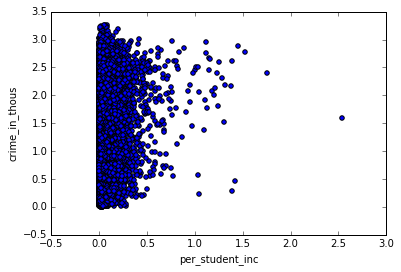

In [63]:
# Excluding grand larceny and norming by school population
#'Thousands of Crimes (excluding Grand Larceny)'
school_df['Felonies (thousands)'] = school_df[NON_LARCENY_COLS].apply(sum, axis=1) / 1000

# School indidents per pupil
school_df['Incidents per student'] = school_df['Total Incidents'] / school_df['Enrollment']

# plot
school_df.plot(x='per_student_inc', y='crime_in_thous', kind='scatter')

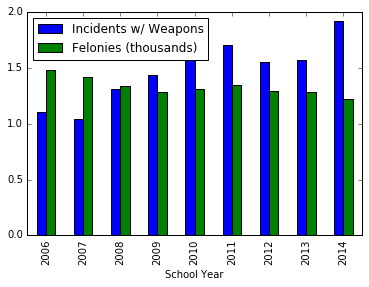

In [64]:
# our weapons tally is still off... need to recompute it and hopefully run the fix on this df directly.
school_df.groupby('School Year')['Incidents w/ Weapons','Felonies (thousands)'].mean().plot(kind='bar', legend=True)

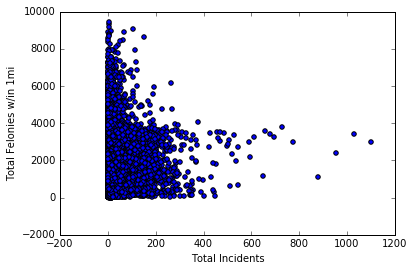

In [38]:
school_df.plot(x='Total Incidents', y='Total Felonies w/in 1mi', kind='scatter')

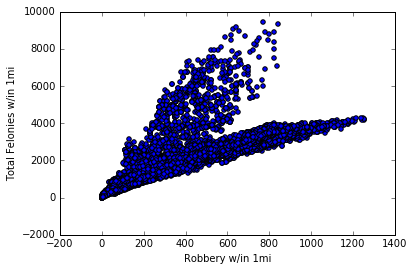

In [59]:
# THIS PLOT doesn't mean anything significant but looks really cool
school_df.plot(x='Robbery w/in 1mi', y='Total Felonies w/in 1mi',  kind='scatter')